# Binary Segmentation w/ U-Net & ENet

kenstler@
smallya@

In this notebook, we will demonstrate how to use SageMaker to **build**, **train**, and **deploy** advanced supervised deep learning algorithms for binary semantic segmentation, a localization technique that classifies at the pixel level. In addition, we will show how custom models such as these can be trained and deployed on the SageMaker platform using custom entry point scripts.

The models used are U-Net and ENet. Both models are fully convolutional neural networks, and fall into a class of neural networks known as auto-encoders. Specifically, we'll be looking at:
* [ENet:A Deep Neural Network for Real-Time Semantic Segmentation](https://arxiv.org/abs/1606.02147)
* [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

ENet (efficient neural network) is a very advanced architecture, leveraging complex microarchitectures to drastically increase efficiency compared to existing methods. U-Net is a more widely known architecture, particularly for medical imaging, and we use it here as a comparison point. 

### Set-up

We're going to use the SageMaker Python SDK to easily interact with the platform, including launching training jobs and deploying endpoints w/ custom code.

In [1]:
import sagemaker
from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker import get_execution_role
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
np.random.seed(1984)

We're going to start by creating two things:
* A SageMaker <tt>Session</tt> object, which manages interactions with the Amazon SageMaker APIs and any other AWS services needed
* An IAM role arn for granting the SageMaker training jobs / endpoint deployments access to your data. <tt>get_execution_role</tt> obtains the role arn that was specified when creating the notebook instance.  

In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

### Generating and Uploading Data

For this tutorial, we're going to generate a synthetic segmentation dataset to train our model on using the AWS Logo.

The goal of semantic segmentation is to predict a mask that indicates the presence of a particular class of object, in this case we have two: 
* The AWS Logo
* The background

Unlike image classification or object detection, the label for a segmentation dataset is the ground truth mask itself. Since we are only doing binary segmentation, this is just an image of 0's and 1's, where 1 indicates the Logo class and 0 indicates the background class.

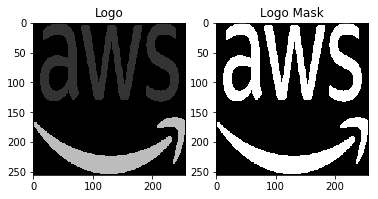

In [3]:
urllib.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Amazon_Web_Services_Logo.svg/2000px-Amazon_Web_Services_Logo.svg.png",
                   "aws_logo.png")

logo = np.array(Image.open('aws_logo.png').convert('L').resize((256, 256)))
logo_mask = (logo != 0).astype(np.uint8)

plt.figure()
plt.subplot(121)
plt.title('Logo')
plt.imshow(logo, cmap=plt.cm.gray)
plt.subplot(122)
plt.title('Logo Mask')
plt.imshow(logo_mask, cmap=plt.cm.gray)

Of course, this example as-is is far too simple, even with standard augmentation, and doesn't resemble a realistic segmentation task at all.

Instead, we're going to generate a more difficult dataset of large images that contain a variable number of warped logos over a noisy background (random noise overlaid with random Gaussian clusters of color), adding noise to the logos themselves, and finally shifting the greyscale values globally to ensure color variation. We merge the warped masks into one to obtain a complete mask.

In [4]:
from gen import generate_dataset
X, Y = generate_dataset(logo, logo_mask, num_samples=100, shape=(720, 720))

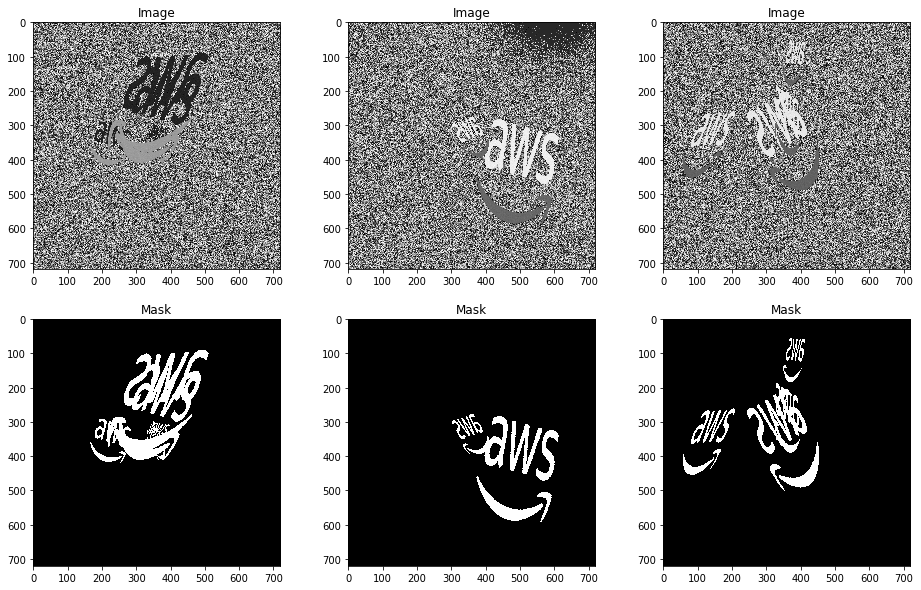

In [5]:
width = 16
height = 10
plt.figure(figsize=(width, height))
plt.subplot(231)
plt.title('Image')
plt.imshow(X[2], cmap=plt.cm.gray)
plt.subplot(232)
plt.title('Image')
plt.imshow(X[3], cmap=plt.cm.gray)
plt.subplot(233)
plt.title('Image')
plt.imshow(X[4], cmap=plt.cm.gray)
plt.subplot(234)
plt.title('Mask')
plt.imshow(Y[2], cmap=plt.cm.gray)
plt.subplot(235)
plt.title('Mask')
plt.imshow(Y[3], cmap=plt.cm.gray)
plt.subplot(236)
plt.title('Mask')
plt.imshow(Y[4], cmap=plt.cm.gray)

We've now generated a non-trivial dataset of 100 720x720 images. We chose this dataset to be 720x720 in order to highlight two common issues encountered when training these models on high-res images:
* Segmentation models usually have a large memory footprint and can only practically train on low-res images
* Downsampling may destroy the finely-grained information we're trying to recover

This issue can be resolved by taking advantage of the fact that segmentation networks are typically **fully convolutional**. Convolutional layers only act on **local** information within a kernel, therefore the size of the input image is irrelevant. Literal edge-cases not withstanding, the kernel weights learned by training on either the entire 720x720 image or smaller patches should achieve similar performance. As a result, we can mitigate the memory constraints by training on the smaller patches instead.

In this tutorial, we will proceed to extract 10 randomly cropped 256x256 patches from each image, subject to typical data augmentation.

In [6]:
def rand_crop(X, Y, shape):
    assert X.shape[0] > shape[0] and X.shape[1] > shape[1]
    delta_row = X.shape[0] - shape[0]
    delta_col = X.shape[1] - shape[1]
    start_row = np.random.randint(delta_row)
    start_col = np.random.randint(delta_col)
    return X[start_row:start_row+shape[0], start_col:start_col+shape[1]], Y[start_row:start_row+shape[0], start_col:start_col+shape[1]]

def generate_random_crops(X, Y, num_patches=10, crop_size=(256, 256)):
    X_crops = []
    Y_crops = []
    for i, x in enumerate(X):
        for j in range(num_patches):
            x_crop, y_crop = rand_crop(x, Y[i], crop_size)
            if np.random.rand() > 0.5:
                x_crop = x_crop[:,::-1]
                y_crop = y_crop[:,::-1]
            if np.random.rand() > 0.5:
                x_crop = x_crop[::-1,:]
                y_crop = y_crop[::-1,:]
            r = np.random.randint(4)
            x_crop, y_crop = np.rot90(x_crop, k=r), np.rot90(y_crop, k=r)
            X_crops.append(x_crop)
            Y_crops.append(y_crop)
    return np.expand_dims(np.stack(X_crops), 1), np.expand_dims(np.stack(Y_crops), 1)

In [7]:
X_crops, Y_crops = generate_random_crops(X, Y)

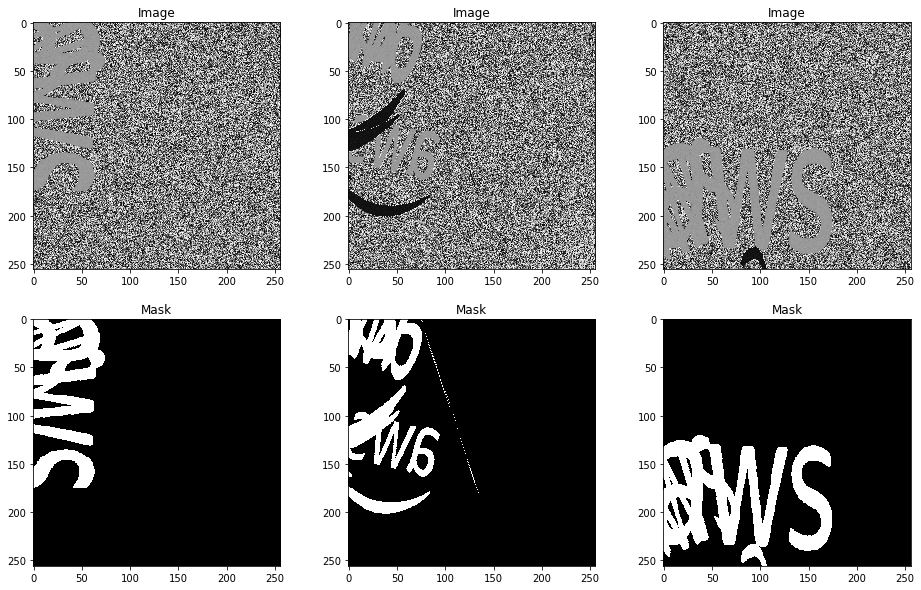

In [8]:
width = 16
height = 10
plt.figure(figsize=(width, height))
plt.subplot(231)
plt.title('Image')
plt.imshow(X_crops[2,0], cmap=plt.cm.gray)
plt.subplot(232)
plt.title('Image')
plt.imshow(X_crops[3,0], cmap=plt.cm.gray)
plt.subplot(233)
plt.title('Image')
plt.imshow(X_crops[4,0], cmap=plt.cm.gray)
plt.subplot(234)
plt.title('Mask')
plt.imshow(Y_crops[2,0], cmap=plt.cm.gray)
plt.subplot(235)
plt.title('Mask')
plt.imshow(Y_crops[3,0], cmap=plt.cm.gray)
plt.subplot(236)
plt.title('Mask')
plt.imshow(Y_crops[4,0], cmap=plt.cm.gray)

In Deep Learning, as in Machine Learning as a whole, we often choose to leave out a portion of our dataset from training to validate our model on unseen data. We'll use an 80-20 train/validation split.

In [9]:
from sklearn.cross_validation import train_test_split

train_X, validation_X, train_Y, validation_Y = train_test_split(X_crops, Y_crops, test_size=0.2)

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now that we have our data prepared, we're going to save the numpy arrays and save them locally. Then we can pass the directory containing our data to the SageMaker session, which uploads the directory and data to the default SageMaker session bucket to be used by our training jobs.

In [10]:
if not os.path.exists('arrays'): os.mkdir('arrays')
if not os.path.exists('arrays/train'): os.mkdir('arrays/train')
if not os.path.exists('arrays/validation'): os.mkdir('arrays/validation')

np.save('arrays/train/train_X.npy', train_X)
np.save('arrays/train/train_Y.npy', train_Y)
np.save('arrays/validation/validation_X.npy', validation_X)
np.save('arrays/validation/validation_Y.npy', validation_Y)

inputs = sagemaker_session.upload_data(path='arrays', key_prefix='segmentation')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208


### Train a model

Now that we've uploaded our data, we can launch a training job using the custom training script <tt>segmentation.py</tt>. This script builds out the model of our choice and runs a custom training loop (see how these scripts are formatted at the repo: https://github.com/aws/sagemaker-python-sdk).

The models we've defined in this script are fairly complex, and we leave it to you to explore their definition on your own. The key function within the training script is the <tt>train</tt> function. This is effectively the <tt>main</tt> function of the training script that is ran when your training job is launched:

```
###############################
###     Training Script     ###
###############################

def train(channel_input_dirs, hyperparameters, hosts, **kwargs):
    # retrieve the hyperparameters we set in notebook (with some defaults)
    model = hyperparameters.get('model', 'enet')
    batch_size = hyperparameters.get('batch_size', 128)
    epochs = hyperparameters.get('epochs', 100)
    learning_rate = hyperparameters.get('learning_rate', 0.1)
    beta1 = hyperparameters.get('beta1', 0.9)
    beta2 = hyperparameters.get('beta2', 0.99)
    mean = hyperparameters.get('mean', [0, 0, 0])
    std = hyperparameters.get('std', [1, 1, 1])
    num_gpus = hyperparameters.get('num_gpus', 0)
    burn_in = hyperparameters.get('burn_in', 5)
    # set logging
    logging.getLogger().setLevel(logging.DEBUG)

    # setup for distributed training
    if len(hosts) == 1:
        kvstore = 'device' if num_gpus > 0 else 'local'
    else:
        kvstore = 'dist_device_sync' if num_gpus > 0 else 'dist_sync'
                              
    # set context for gpu if available, else cpu
    ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
    print (ctx)
    f_path = channel_input_dirs['training']
    # load data
    train_X, train_Y, validation_X, validation_Y = get_data(f_path)
    
    print ('loaded data')
    # define MXNet iterators
    train_iter = train_iter = mx.io.NDArrayIter(data = train_X, label=train_Y, batch_size=batch_size, shuffle=True)
    validation_iter = mx.io.NDArrayIter(data = validation_X, label=validation_Y, batch_size=batch_size, shuffle=False)
    data_shape = (batch_size,) + train_X.shape[1:]

    print ('created iters')
    
    print ('building %s' % model)
    # build relevant model
    if model == 'enet':
        sym = build_enet(inp_dims=data_shape[1:])
    else:
        sym = build_unet()
    # build network, bind to data shapes, and initialize parameters and optimizer
    net = mx.mod.Module(sym, context=ctx, data_names=('data',), label_names=('label',))
    net.bind(data_shapes=[['data', data_shape]], label_shapes=[['label', data_shape]])
    net.init_params(mx.initializer.Xavier(magnitude=6))
    net.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', learning_rate),
                                   ('beta1', beta1),
                                   ('beta2', beta2)
                              ))
    # begin training loop, tracking loss values
    print ('start training')
    smoothing_constant = .01
    curr_losses = []
    moving_losses = []
    i = 0
    best_val_loss = np.inf
    for e in range(epochs):
        while True:
            # if iterator is out, reset and move to next epoch
            try:
                batch = next(train_iter)
            except StopIteration:
                train_iter.reset()
                break
            # forward and backward pass
            net.forward_backward(batch)
            loss = net.get_outputs()[0]
            # optimizer step
            net.update()
            # loss calculations
            curr_loss = F.mean(loss).asscalar()
            curr_losses.append(curr_loss)
            moving_loss = (curr_loss if ((i == 0) and (e == 0))
                                   else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
            moving_losses.append(moving_loss)
            i += 1
        # loss metrics
        val_losses = []
        for batch in validation_iter:
            net.forward(batch)
            loss = net.get_outputs()[0]
            val_losses.append(F.mean(loss).asscalar())
        validation_iter.reset()
        # early stopping
        val_loss = np.mean(val_losses)
        # early stopping by saving the model w/ best validation metric
        if e > burn_in and val_loss < best_val_loss:
            best_val_loss = val_loss
            net.save_checkpoint('best_net', 0)
            print("Best model at Epoch %i" %(e+1))
        print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))
    # load the model with the best validation metrics, then
    net.load_params('best_net-0000.params')
    return net
```

We can now define the MXNet estimator that will launch the training job with this script as the entry point.

We're going to pass some arguments defining model choice and training procedure, as all as hyperparameters typical to training neural networks:
* **model**: one of <tt>enet</tt> or <t>unet</tt>, the two architectures we've defined in our script. ENet is designed to be much more efficient than UNet, but you may find UNet performs better in certain use-cases.
* **burn_in**: Our custom training loop uses **early stopping**, meaning that the model we return is not the model that performs best on the training data but on the validation data. To do this, we save models locally when they surpass a previous validation metric. <tt>burn_in</tt> is the number of epochs to wait before we start doing this, since early epochs will almost always consecutively improve validation metrics. **Note**: This must be lower than <tt>epochs</tt>, or no model is saved and an error is thrown.
* **batch_size**: the size of the mini batch trained on at a given time. As mentioned, these networks have a large memory footprint so we're only using 2. This may be small for standard CNN's, but it is less important in a Fully Convolutional network.
* **epochs**: number of times to pass through the training set
* **learning rate**: Learning rate for the **Adam** optimizer
* **num_gpus**: The number of gpu's we wish to train on. This is only applicable to GPU Instances, and can never be more than the batch size.

In [20]:
enet = MXNet("segmentation.py", 
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p2.xlarge",
          hyperparameters={
                         'model': 'enet',
                         'burn_in': 5,
                         'batch_size': 2, 
                         'epochs': 10, 
                         'learning_rate': 1E-3, 
                         'num_gpus': 1,
                          })

Next we call the fit method. SageMaker launches the specified EC2 instance(s), downloads the data from the S3 bucket specified in <tt>inputs</tt>, and runs the training script.

**Note:** The next cell may take 15 minutes to train at 10 epochs. Feel free to change to less for a quick demo.

In [23]:
enet.fit(inputs)

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-gpu-2018-02-16-23-26-01-883


..........................................................................
executing startup script (first run)
2018-02-16 23:32:02,312 INFO - root - running container entrypoint
2018-02-16 23:32:02,313 INFO - root - starting train task
2018-02-16 23:32:03,851 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'segmentation.py', u'num_gpus': 1, u'learning_rate': 0.001, u'batch_size': 2,

This model is saved to S3, and we use this artifact in the next step.

### Create endpoint and predictor

Now that we have a trained model, we can use the SageMaker platform to deploy it to an endpoint. The <tt>deploy</tt> method launches an EC2 instance of the specified type, loads the model, and sets up an inference service that responds to requests. This is all customizable, but our code only provides manual model loading and uses the default inference serving. The <tt>model_fn</tt> method defines how the model is loaded once the endpoint is provisioned:
```
###############################
###     Hosting Methods     ###
###############################

def model_fn(model_dir):
    sym, arg_params, aux_params = mx.model.load_checkpoint('%s/model' % model_dir, 0)
    with open('%s/model-shapes.json' % model_dir) as f:
        shapes = json.load(f)
    shape = shapes[0]['shape']
    batch_size = 1
    data_shape = (batch_size, 1, shape[2], shape[3])
    net = mx.mod.Module(sym, data_names=('data',), label_names=('label',))
    net.bind(data_shapes=[['data', data_shape]], label_shapes=[['label', data_shape]], for_training=False)
    net.set_params(arg_params, aux_params)
    return net
```


**Note:** Remember to delete the endpoint after running this experiment. You can find the cell for endpoint deletion at the section **Delete Endpoint**.

In [35]:
enet_predictor = enet.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-gpu-2018-02-16-23-26-01-883
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-gpu-2018-02-16-23-26-01-883


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------!

### Make predictions and plot results

Now that the inference server is running on the endpoint, we're going to send data for inference. 

The <tt>MXNetPredictor</tt> object by default serializes the input and sends it in an HTTP request to the endpoint. Here, we select a validation data point to send, and convert it into a list to send.

In [59]:
payload = np.expand_dims(validation_X[0], 0).tolist()

The <tt>predict</tt> method sends the data to the server and waits for a response, which comes as the output of the network as a list.

In [ ]:
enet_response = enet_predictor.predict(payload)

The output comes as per-pixel sigmoid activations at the last layer.

In [43]:
np.array(enet_response[1])

array([[[[  2.10151948e-11,   4.49309027e-11,   1.20933049e-12, ...,
            1.87480564e-09,   9.99877181e-10,   5.05284037e-09],
         [  3.08736370e-11,   6.42012485e-12,   1.66873752e-12, ...,
            5.88720905e-10,   7.47021667e-10,   1.54327051e-09],
         [  1.58891346e-12,   9.37142204e-12,   7.81887413e-13, ...,
            2.26696639e-09,   4.15856322e-10,   5.19906429e-09],
         ..., 
         [  9.94163930e-01,   9.99896288e-01,   9.99478638e-01, ...,
            3.64669073e-10,   3.18296972e-10,   1.46757984e-09],
         [  9.68406498e-01,   9.98887479e-01,   9.99686480e-01, ...,
            2.11365769e-09,   1.53638924e-09,   1.05763949e-08],
         [  6.30198598e-01,   9.75323021e-01,   9.83277380e-01, ...,
            6.03937400e-10,   5.51216517e-10,   2.31737296e-09]]]])

We need to do some post-processing to make classification. Here we use a typical operating point of 0.5, but others can be chosen where appropriate.

In [44]:
def post_process_mask(label, p=0.5):
    return (np.where(label > p, 1, 0)).astype('uint8')

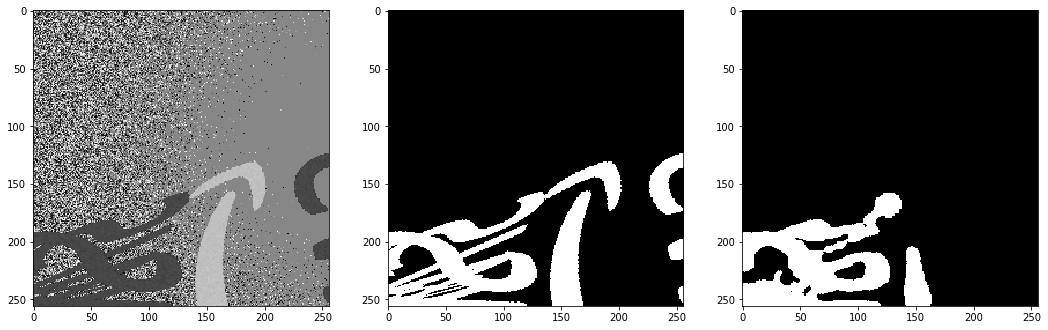

In [45]:
width = 18
height = 18
plt.figure(figsize=(width, height))
plt.subplot(131)
plt.imshow(validation_X[0][0], cmap=plt.cm.gray)
plt.subplot(132)
plt.imshow(validation_Y[0][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.imshow(post_process_mask(np.array(enet_response[1][0][0])), cmap=plt.cm.gray)


At only 10 epochs, we're getting fairly good results, but the model is having issues with the finer details and the Gaussian blob backgrounds. Further training yields us better results, w/ > .95 Dice at 100 epochs.

Let's look at some more examples.

In [51]:
payloads = [np.expand_dims(validation_X[i], 0).tolist() for i in np.arange(10, 13)]

responses = []
for payload in payloads:
    response = enet_predictor.predict(payload)
    responses.append(response)

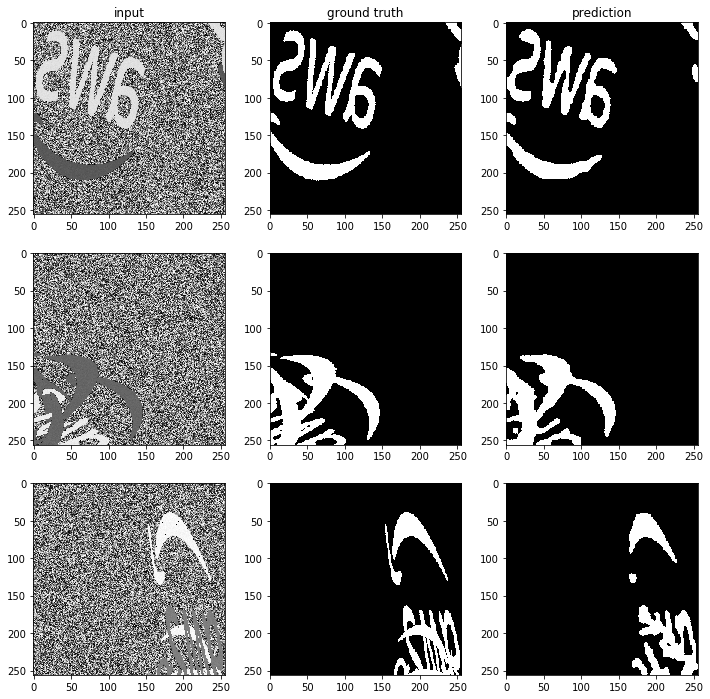

In [52]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('input')
plt.imshow(validation_X[10][0], cmap=plt.cm.gray)
plt.subplot(332)
plt.title('ground truth')
plt.imshow(validation_Y[10][0], cmap=plt.cm.gray)
plt.subplot(333)
plt.title('prediction')
plt.imshow(post_process_mask(np.array(responses[0][1][0][0])), cmap=plt.cm.gray)
plt.subplot(334)
plt.imshow(validation_X[11][0], cmap=plt.cm.gray)
plt.subplot(335)
plt.imshow(validation_Y[11][0], cmap=plt.cm.gray)
plt.subplot(336)
plt.imshow(post_process_mask(np.array(responses[1][1][0][0])), cmap=plt.cm.gray)
plt.subplot(337)
plt.imshow(validation_X[12][0], cmap=plt.cm.gray)
plt.subplot(338)
plt.imshow(validation_Y[12][0], cmap=plt.cm.gray)
plt.subplot(339)
plt.imshow(post_process_mask(np.array(responses[2][1][0][0])), cmap=plt.cm.gray)

### Delete Endpoint

In [53]:
enet.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-py2-gpu-2018-02-16-23-26-01-883


### Re-deploying model for Full Resolution

Recall that we trained our network on random crops of larger images. We did this because the network used was Fully Convolutional, and the weights learned to make local decisions in the smaller case should be applicable to the full resolution case.

In order to test out our model at the whole resolution, we're going to build a new Model object specifically for inference, and pass it a modified inference script that specifically binds the model to the resolution desired:

```
###############################
###     Hosting Methods     ###
###############################

def model_fn(model_dir):
    _, arg_params, aux_params = mx.model.load_checkpoint('%s/model' % model_dir, 0)
    batch_size = 1
    data_shape = (batch_size, 1, 720, 720)
    sym = build_enet(data_shape[1:])
    net = mx.mod.Module(sym, data_names=('data',), label_names=('label',))
    net.bind(data_shapes=[['data', data_shape]], label_shapes=[['label', data_shape]], for_training=False)
    net.set_params(arg_params, aux_params)
    return net
```

We can build this object (<tt>MXNetModel</tt>, not <tt>MXNet</tt>) by directly passing it the location of the trained model on S3. We deploy exactly as before.

In [58]:
model_path = enet.model_data

enet_full_res = MXNetModel(
    model_data=model_path, role=role, entry_point="enet_full_res_deploy.py")

enet_full_res_predictor = enet_full_res.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-gpu-2018-02-17-01-18-43-167
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-gpu-2018-02-17-01-18-43-167


---------------------------------------------------------------------------------------------------------------!

Next, we'll submit some data for inference as before.

In [61]:
payloads = [np.expand_dims(np.expand_dims(X[i], 0), 0).tolist() for i in np.arange(3)]

responses = []
for payload in payloads:
    response = enet_full_res_predictor.predict(payload)
    responses.append(response)

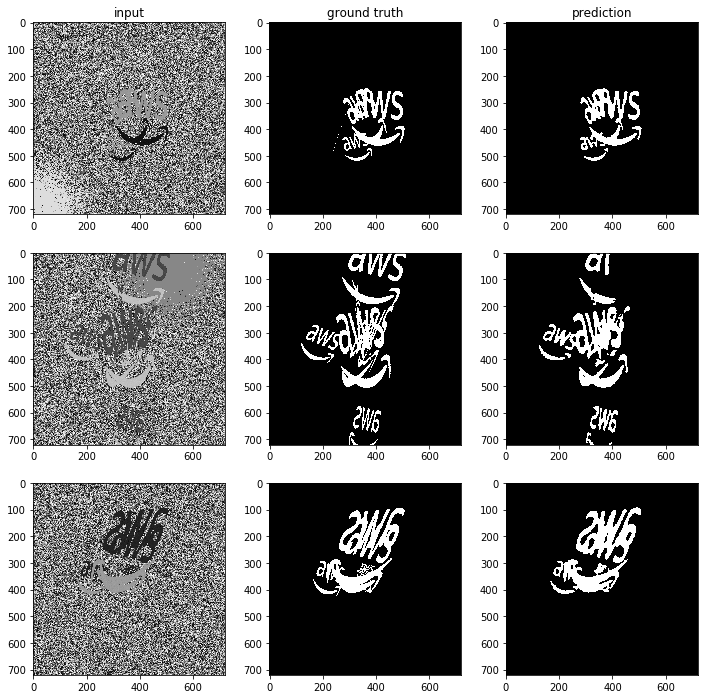

In [62]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('input')
plt.imshow(X[0], cmap=plt.cm.gray)
plt.subplot(332)
plt.title('ground truth')
plt.imshow(Y[0], cmap=plt.cm.gray)
plt.subplot(333)
plt.title('prediction')
plt.imshow(post_process_mask(np.array(responses[0][1][0][0])), cmap=plt.cm.gray)
plt.subplot(334)
plt.imshow(X[1], cmap=plt.cm.gray)
plt.subplot(335)
plt.imshow(Y[1], cmap=plt.cm.gray)
plt.subplot(336)
plt.imshow(post_process_mask(np.array(responses[1][1][0][0])), cmap=plt.cm.gray)
plt.subplot(337)
plt.imshow(X[2], cmap=plt.cm.gray)
plt.subplot(338)
plt.imshow(Y[2], cmap=plt.cm.gray)
plt.subplot(339)
plt.imshow(post_process_mask(np.array(responses[2][1][0][0])), cmap=plt.cm.gray)

And we can see the model works on the full imafges as well!

We've demonstrated that we can build a Fully Convolutional Neural Network for high-resolution segmentation inference by training the model on low-resolution patches / crops of the desired data.

### Delete Endpoint

In [93]:
sagemaker_session.delete_endpoint(enet_full_res.endpoint_name)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-py2-gpu-2018-02-15-06-52-22-023
